## Monthly Long Only strategy

The goal of this worksheet is to implement a simple portfolio model suitable for finance professionals with strict trading restrictions.  It might also be suitable for others.

The following restrictions will be assumed:

- monthly trading: many will have a 30-day holding period, so we will assume that we trade following a month-end
- long-only: many can't go short, so we will stay long
- no derivatives: futures and options aren't permitted for many, so we will stick to equities and, primarily, etfs
- cash account: no explicit leverage can be used; levered etfs are ok

The following characteristics will be desired:

- we're not looking to hit a home run, but to maintain balanced exposure to the world's beta/risk premia sources
- we're hoping for a reasonably docile mix with best possible risk/return characteristics which can be levered to the taste (and restrictions) of the individual

The portfolio will contain the following conceptual buckets and candidate etfs/funds.  For the etfs, I will only consider high liquidity and low cost etfs.  This is generally feasible with the exception of commodities and volatility.   We will look at alternatives for those baskets.  Some good etfs (eg, BND) are category busters, so the below table is imprecise but should be in the ballpark. 

The last column is a highly speculative approximate weight.  This is a risk weight and is meant to be very loose.  The intention is simply to be able to constrain weights within conceptual buckets so we don't find ourselves wildly overweight, say gold.  We'll look further at weighting approaches below.

| Asset/Theme       | Potential ETFs          | ~Weight     |
|-------------------|-------------------------|-------------|
| Commodities       | DJP, IAU                |   5%        |
| Equities          | VOO, VTI, VWO           |  40%        |
| Inflation-linked  | VTIP                    |  20%        |
| Nominal Bonds     | BND, VWOB               |  20%        |
| Corporates        | VCLT, VCIT, VCSH, VWEHX |   5%        |
| Real Estate       | VNQ, VNQI               |   0%        |
| Volatility        | VMIN                    |   0%        |
| Misc              | GHS, VMIN,...           |  10%        |

I've zeroed out Real Estate since I'm already more than sufficiently exposed to it and Volatility since I don't like any of the etfs and hope we can get similar behavior from the breadth of portfolio...

The unallocated remainder of the portfolio can be left in cash or deployed to thematic preferences.  Since I will be trading this in a cash account, I will most likely use the misc bucket with levered instruments like VMIN or GHS to add some volatility to the portfolio.

OK, now let's look at some data for these instruments.

### preliminaries

In [1]:
library(PerformanceAnalytics)
library(futile.logger)
library(data.table)
library(ggplot2)
library(quantmod)
library(TTR)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend


Attaching package: ‘data.table’

The following objects are masked from ‘package:xts’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.


In [2]:
# pulls data for sym from yahoo, returns prices & returns as timeseries in list
from.yahoo <- function( sym ) {
    URL <- paste("http://ichart.finance.yahoo.com/table.csv?s=",sym,sep='')
    raw <- read.csv(URL)
    raw$Date <- as.Date(raw$Date, "%Y-%m-%d")
    P <- xts( raw$Adj.Close, order.by=raw$Date )
    R <- Return.calculate(P)
    names(P) <- names(R) <- sym
    flog.info(paste('Pulled data for',sym))
    list(P,R)
}

### now let's get the data

In [3]:
allsyms <- c('DJP', 'IAU', 'VOO', 'VTI', 'VWO', 'VTIP', 'BND', 'VWOB', 'PPT',
             'VCLT','VCIT','VCSH','VNQ','VNQI', 'GHS', 'VMIN')

ALL <- lapply(allsyms, from.yahoo)
names(ALL) <- allsyms

INFO [2017-02-15 10:13:29] Pulled data for DJP
INFO [2017-02-15 10:13:30] Pulled data for IAU
INFO [2017-02-15 10:13:30] Pulled data for VOO
INFO [2017-02-15 10:13:30] Pulled data for VTI
INFO [2017-02-15 10:13:30] Pulled data for VWO
INFO [2017-02-15 10:13:30] Pulled data for VTIP
INFO [2017-02-15 10:13:31] Pulled data for BND
INFO [2017-02-15 10:13:31] Pulled data for VWOB
INFO [2017-02-15 10:13:31] Pulled data for PPT
INFO [2017-02-15 10:13:32] Pulled data for VCLT
INFO [2017-02-15 10:13:32] Pulled data for VCIT
INFO [2017-02-15 10:13:32] Pulled data for VCSH
INFO [2017-02-15 10:13:32] Pulled data for VNQ
INFO [2017-02-15 10:13:33] Pulled data for VNQI
INFO [2017-02-15 10:13:33] Pulled data for GHS
INFO [2017-02-15 10:13:33] Pulled data for VMIN


### we'll create two universes: P will contain prices and R will contain returns

In [4]:
#head(ALL[['VMIN']][[1]])

rollem <- function(sym,idx) {
    ALL[[sym]][[idx]]
}
P <- do.call('merge',lapply( allsyms, rollem, 1) )
R <- do.call('merge',lapply( allsyms, rollem, 2) )


### let's visualize and get some stats

,DJP,IAU,VOO,VTI,VWO,VTIP,BND,VWOB,PPT,VCLT,VCIT,VCSH,VNQ,VNQI,GHS,VMIN
Annualized Return,-0.0642,0.0883,0.1467,0.0704,0.0637,0.0010,0.0409,0.0409,0.0685,0.0736,0.0568,0.0297,0.0917,0.0472,0.1567,2.8798
Annualized Std Dev,0.1859,0.1964,0.1474,0.1931,0.3044,0.0184,0.0475,0.0599,0.1765,0.0953,0.0473,0.0187,0.3288,0.1733,0.1533,0.7645
Annualized Sharpe (Rf=0%),-0.3453,0.4497,0.9950,0.3646,0.2093,0.0520,0.8606,0.6837,0.3879,0.7725,1.2007,1.5851,0.2789,0.2723,1.0222,3.7672


,DJP,IAU,VOO,VTI,VWO,VTIP,BND,VWOB,PPT,VCLT,VCIT,VCSH,VNQ,VNQI,GHS,VMIN
Worst Drawdown,0.7295227,0.4513514,0.1875457,0.5545376,0.6768327,0.03682244,0.09313158,0.07739582,0.4975698,0.1365167,0.07425566,0.02530593,0.7306553,0.2453187,0.1306567,0.4383518


,DJP,IAU,VOO,VTI,VWO,VTIP,BND,VWOB,PPT,VCLT,VCIT,VCSH,VNQ,VNQI,GHS,VMIN
Kelly Ratio,-0.7092036,1.347414,3.400549,1.162723,0.5822121,1.665877,9.124359,5.847052,1.311462,4.160066,12.58915,41.97776,0.6558153,1.018251,3.347121,1.427761


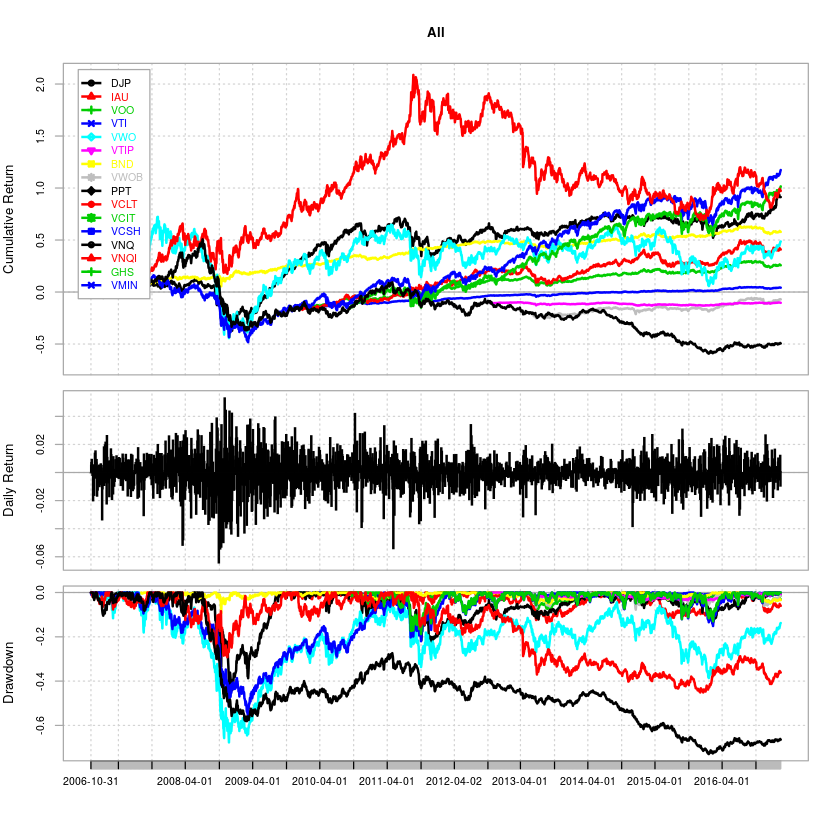

In [5]:
charts.PerformanceSummary(R, main='All')
table.AnnualizedReturns(R)
maxDrawdown(R)
KellyRatio(R)

### for fun, let's look at equal- and volatility- weighted performance

,eq,inv.vol
Annualized Return,0.0509,0.0295
Annualized Std Dev,0.0795,0.0296
Annualized Sharpe (Rf=0%),0.6404,0.9961


,eq,inv.vol
Worst Drawdown,0.2072245,0.06774567


,eq,inv.vol
Kelly Ratio,4.176731,16.83018


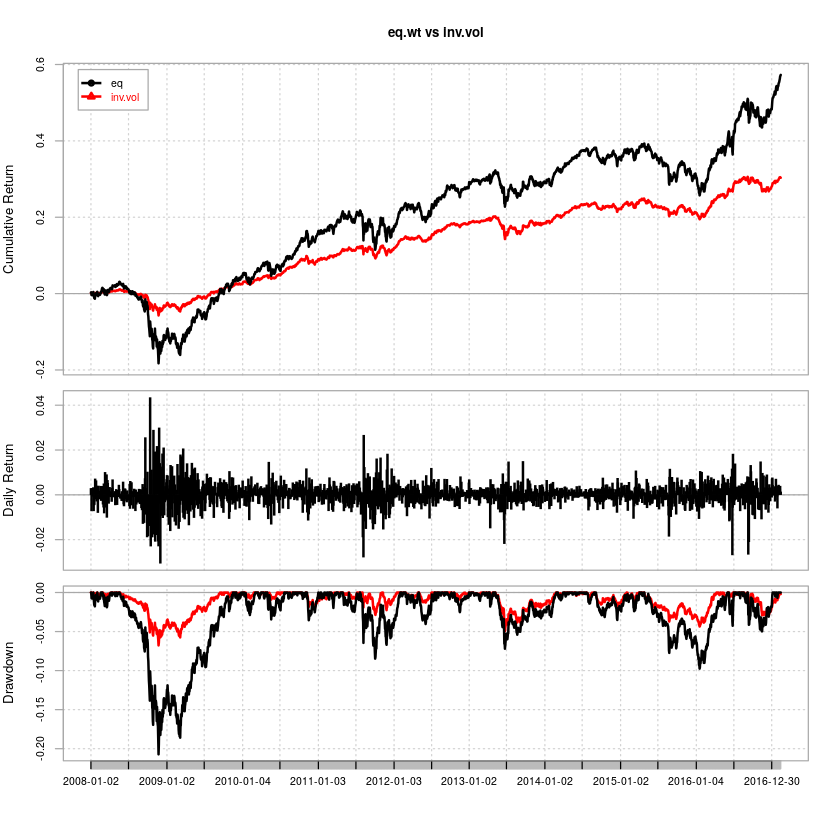

In [6]:
# eq wt is just:
eq <- xts(rowSums(R,na.rm=TRUE)/ncol(R), order.by=index(R))

#inverse-vol:
a <- table.AnnualizedReturns(R)
R[is.na(R)] <- 0

v <- a[2,]
iv <- (1/v) /sum(1/v)
inv.vol <- as.xts(as.matrix(R) %*% t(as.vector(iv)), order.by=index(R))
names(inv.vol) <- 'inv.vol'

both <- merge(eq,inv.vol)['2008-01-01/']

charts.PerformanceSummary(both, main='eq.wt vs inv.vol')
table.AnnualizedReturns(both)
maxDrawdown(both)
KellyRatio(both)


### Looks like the basic mix should work in a variety of seasons, now let's look at our original mix

It's worth noting that the inverse vol portfolio is better on a ratio basis than equal weighting, but both are basically sound.  

It's also worth noting that the inverse vol portfolio, as implemented, has a look-ahead bias as we use the entire periods' volatility to set our weights.

In the weighting I apply below, I put a lot of weight into two very dubious ETFs: GHS and VMIN.  GHS gives levered, equal S&P and Gold exposure through futures.  VMIN gives short vol exposure through weekly futures.  Neither has meaningful money under management and could very well disappear and represent a liquidity risk as well.  But the occupy a limited portion of the overall portfolio and I do want more volatility than the portfolio provides and this is how I will take it for now...

Finally, it's important to note that many of these etfs, GHS and VMIN in particular, are newer and thus their effect isn't seen throughout the whole time period.  One would expect a generally higher level of vol than what is reported below.

In [7]:
# ok, so let's set weights according roughly to our original guidelines...
#             DJP  IAU VOO VTI VWO VTIP BND VWOB  PPT VCLT VCIT VCSH VNQ VNQI  GHS VMIN
weights <- c( .01, .02, .2, .1, .1, .2, .15, .05,  0, .01, .01,  .0,   0,   0, .1, .05)
#weights.sg <- c( 0,1,       1,     0,    0,    .0,   .0,  .0,    .0,  .0,  .0,      0, 0 )
sum(weights)


[1] 1

,fixed
Annualized Return,0.0505
Annualized Std Dev,0.0725
Annualized Sharpe (Rf=0%),0.6972


[1] 0.1501804

,fixed
Kelly Ratio,4.942563


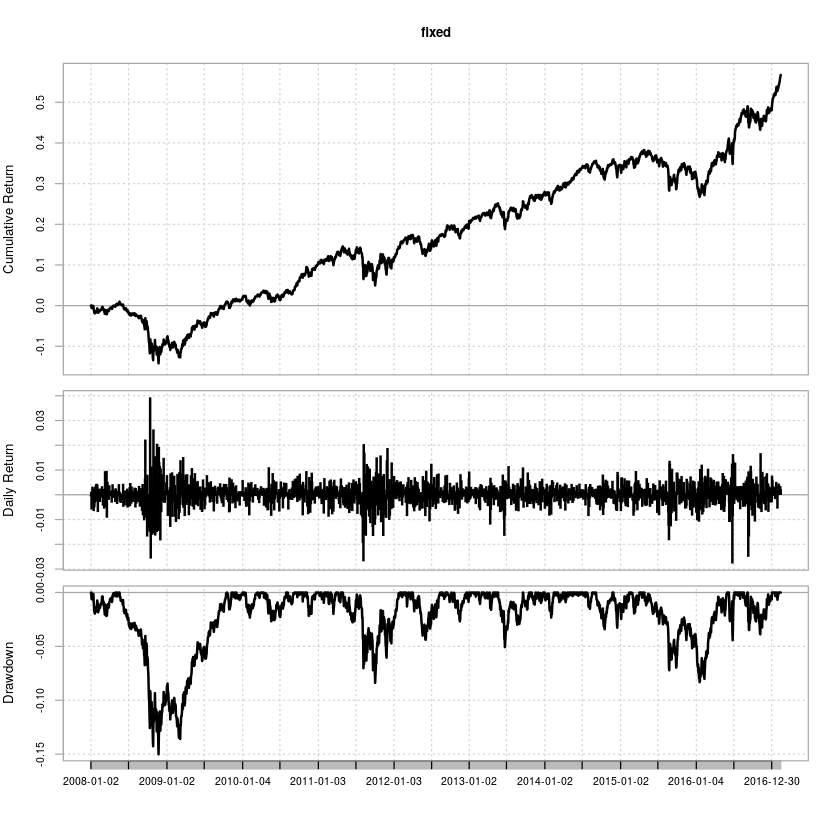

In [8]:
fixed <- as.xts(as.matrix(R) %*% as.vector(weights), order.by=index(R))
names(fixed) <- 'fixed'

fixed <- fixed['2008-01-01/']

charts.PerformanceSummary(fixed, main='fixed')
table.AnnualizedReturns(fixed)
maxDrawdown(fixed)
KellyRatio(fixed)

### TODO: stop-loss ??

In [9]:
# Let's add a per-name stop loss: if we're below the 10m moving average, we're out.  
# for each day and instrument in the universe, we're going to introduce a value between 0 and 1 indicating our 
# name-weight for the day

# first we need our 10-month moving average which, since we're looking at daily data is, say, 200 days.

#S <- P
#S[S>0] <- 1
#S[is.na(S)] <- 1

#head(S)
#tail(S)

### TODO: value-signal ??

### let's see what this portfolio would look like if implemented today on $100K

In [10]:
# now, let's assume we have $100,000 we'd like to apply this strategy to right about now
tail(P)
last.price <- apply(P, 2, function(x) tail(na.omit(x), 1))

CASH <- 100000

tospend <- CASH * weights
sum(tospend)
shares <- tospend / last.price
    
df <- data.frame(last.price,tospend,shares,weights)
df <- df[df$tospend>0,]
df
dim(df)   

             DJP   IAU    VOO    VTI   VWO  VTIP   BND  VWOB  PPT  VCLT  VCIT
2017-02-07 24.30 11.87 210.25 118.13 38.06 49.39 81.08 78.96 5.28 89.61 86.23
2017-02-08 24.47 11.94 210.52 118.26 38.36 49.37 81.30 79.24 5.23 90.19 86.40
2017-02-09 24.47 11.86 211.72 119.04 38.56 49.34 81.08 79.12 5.23 89.63 86.08
2017-02-10 24.78 11.89 212.57 119.54 38.91 49.35 81.06 79.18 5.23 89.74 86.08
2017-02-13 24.53 11.81 213.70 120.14 39.06 49.30 80.97 79.34 5.23 89.60 86.00
2017-02-14 24.55 11.82 214.59 120.58 39.12 49.24 80.80 79.16 5.23 89.35 85.82
            VCSH   VNQ  VNQI    GHS   VMIN
2017-02-07 79.64 82.37 51.60 27.870 31.010
2017-02-08 79.71 83.02 52.08 28.140 30.650
2017-02-09 79.65 83.22 52.36 28.140 31.780
2017-02-10 79.63 83.81 52.42 28.250 32.340
2017-02-13 79.62 83.84 52.25 28.099 33.316
2017-02-14 79.56 83.40 52.30 28.130 34.200

[1] 1e+05

,last.price,tospend,shares,weights
DJP,24.55,1000,40.73320,0.01
IAU,11.82,2000,169.20474,0.02
VOO,214.59,20000,93.20099,0.20
VTI,120.58,10000,82.93249,0.10
VWO,39.12,10000,255.62373,0.10
VTIP,49.24,20000,406.17383,0.20
BND,80.80,15000,185.64356,0.15
VWOB,79.16,5000,63.16321,0.05
VCLT,89.35,1000,11.19194,0.01
VCIT,85.82,1000,11.65230,0.01


[1] 12  4

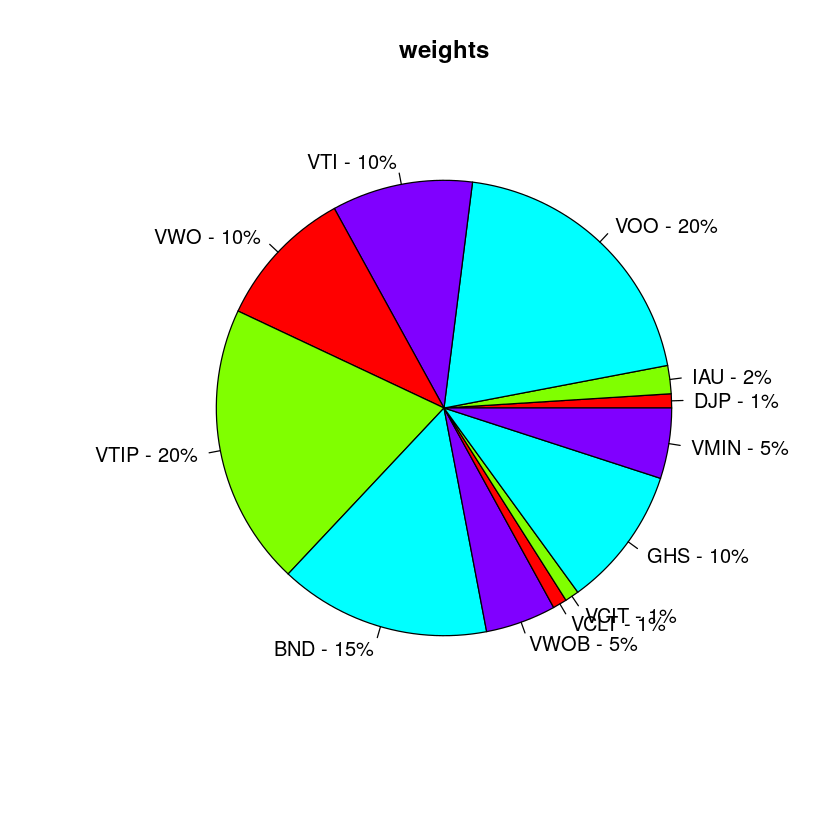

In [11]:
labels <- paste(row.names(df), ' - ',100*df$weights, '%',sep='')
pie(df$weights,labels = labels, col=rainbow(length(df)),main="weights")

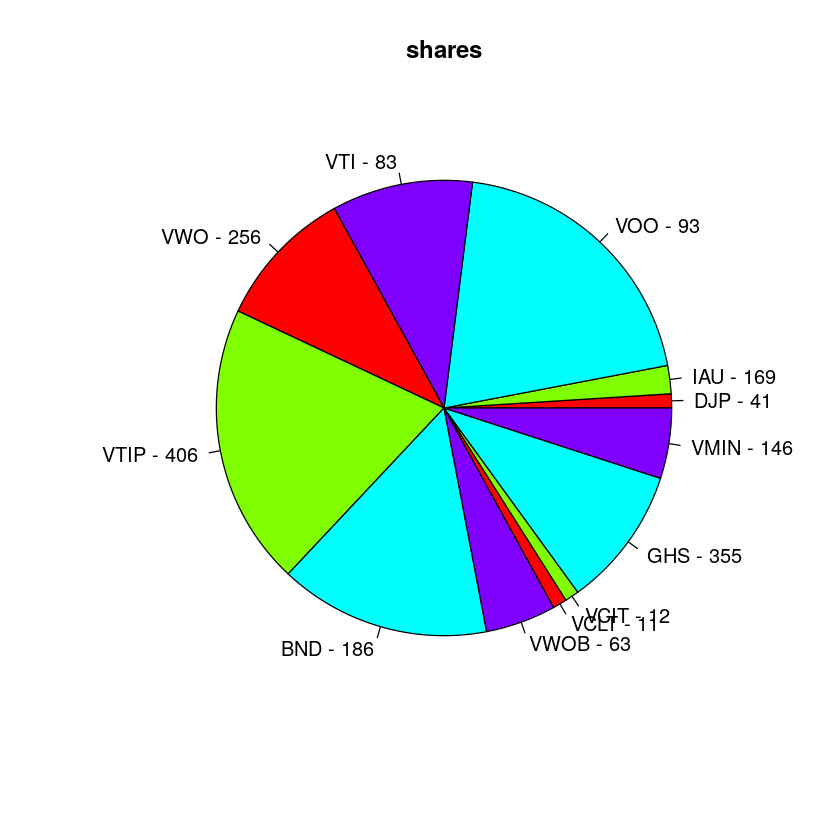

In [12]:
labels <- paste(row.names(df), ' - ',round(df$shares), sep='')
pie(df$weights,labels = labels, col=rainbow(length(df)),main="shares")